# Visualizing GEDI_L2A Dataset in R

Authors: Harshini Girish (UAH), Sheyenne Kirkland (UAH), Alex Mandel (Development Seed), Chuck Daniels (Development Seed)

Date: July 29, 2025

Description: This notebook reads a GEDI dataset stored in Parquet format and converts it into a spatial `sf` object using its geometry column. A bounding box is defined using geographic coordinates to extract a spatial subset of the data. Points falling within this bounding area are filtered using `st_intersects()` and stored for analysis. Key attributes such as elevation and sensitivity are extracted and combined with geographic coordinates to create a clean display-ready DataFrame. Finally, the filtered points and bounding box are visualized on an interactive Leaflet map, enabling geographic inspection of shot-level GEDI metrics.


## Run This Notebook

To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors. Users should work within the "R/Python" workspace.

## Additional Resources
 
- [GEDI L2A Product Documentation](https://docs.maap-project.org/en/troubleshooting-section/science/GEDI/GEDI_L2A.html): A science-focused overview of the GEDI L2A product structure, measurement principles, and available variables, including footprint-level elevation, sensitivity, and quality flags.

- [Accessing GEDI Data in R](https://docs.maap-project.org/en/troubleshooting-section/technical_tutorials/working_with_r/gedi_access_r.html): Step-by-step tutorial for accessing and loading GEDI HDF5 or GeoParquet files into R using packages like `arrow`, `sf`, and `rhdf5`, with examples tailored for the MAAP ADE.

- [Submitting R Jobs in MAAP](https://docs.maap-project.org/en/troubleshooting-section/technical_tutorials/working_with_r/submitting_jobs_r.html): A tutorial that demonstrates how to submit R scripts as batch jobs within the MAAP Algorithm Development Environment (ADE), including workspace setup and job status tracking.


## Install/Import Libraries
Let’s install and load the packages necessary for this tutorial.

In [69]:
library(arrow)
library(sf)
library(dplyr)
library(leaflet)
library(tmap)
library(rnaturalearth)
data(World)

## Load the dataset

This line reads a Parquet file from the MAAP shared path into a DataFrame `df`. This file path points to a location within the MAAP environment where user and shared project files are stored.

In [61]:
df <- read_parquet("/projects/shared-buckets/harshinigirish/gedi_subset.parquet")
df_sf <- st_as_sf(df, crs = 4326)  


## Preview the Data

The dataset is read into R using `read_parquet()`. Geometry is parsed into spatial format (EPSG:4326) and the DataFrame is converted to an `sf` object. Coordinates are extracted, and a cleaned summary table (`sample_df`) is created with beam ID, shot number, location, elevation, and sensitivity values. This prepares the data for spatial analysis and visualization.


In [44]:
colnames(df)


[1] "filename"                   "agbd"                      
[3] "agbd_se"                    "sensitivity"               
[5] "geolocation/sensitivity_a2" "elev_lowestmode"           
[7] "geometry"

In [62]:
# Now convert to sf object
df_sf <- st_sf(df)


In [55]:
# Extract coordinates
coords <- st_coordinates(df_sf)

sample_df <- data.frame(
  Beam = "BEAM0000",
  `Shot Number` = seq_len(nrow(df_sf)),
  Longitude = coords[, "X"],
  Latitude = coords[, "Y"],
  `Elevation (Lowest Mode)` = df_sf$elev_lowestmode,
  `Sensitivity A2` = df_sf$`geolocation/sensitivity_a2`,
  `AGBD` = df_sf$agbd,
  `AGBD SE` = df_sf$agbd_se
)
head(sample_df)

,Beam,Shot.Number,Longitude,Latitude,Elevation..Lowest.Mode.,Sensitivity.A2,AGBD,AGBD.SE
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BEAM0000,1,85.38437,28.03722,4061.177,0.9834459,425.90472,3.443850
2,BEAM0000,2,85.38864,28.04138,4282.283,0.9835913,70.76015,3.006401
3,BEAM0000,3,85.38903,28.04176,4271.902,0.9795517,10.27938,2.986123
4,BEAM0000,4,85.38943,28.04215,4245.282,0.9783008,108.70986,3.040855
5,BEAM0000,5,85.39292,28.04556,4397.378,0.9845160,107.70087,3.039851
6,BEAM0000,6,85.39371,28.04633,4345.177,0.9795770,214.08157,3.160618


## Leaflet-Based Visualization

This step creates an interactive Leaflet map to visualize shot locations from the `sample_df` dataset. Each point is plotted as a circle using its longitude and latitude, with a popup label showing the shot number. The map uses OpenStreetMap tiles and is centered on the mean coordinates of all points. A zoom level of 12 ensures a detailed local view. 

In [59]:
leaflet_map <- leaflet(data = sample_df) %>%
  addProviderTiles("OpenStreetMap") %>%
  addCircles(
    lng = ~Longitude,
    lat = ~Latitude,
    radius = 50,
    popup = ~paste(
      "Shot Number:", Shot.Number, "<br>",
      "AGBD:", AGBD, "<br>",
      "AGBD SE:", AGBD.SE, "<br>",
      "Elevation (Lowest Mode):", Elevation..Lowest.Mode., "<br>",
      "Sensitivity A2:", Sensitivity.A2
    )
  ) %>%
  setView(
    lng = mean(sample_df$Longitude, na.rm = TRUE),
    lat = mean(sample_df$Latitude, na.rm = TRUE),
    zoom = 12
  )

# Show the map
leaflet_map


HTML widgets cannot be represented in plain text (need html)

## Spatial Filtering and Visualization Using a Bounding Box


A bounding box is defined using specific longitude and latitude limits to focus on a smaller spatial region. Points from the dataset are filtered to include only those within this bounding box using `st_intersects()`.The resulting points and the bounding box are visualized together on an interactive Leaflet map.


In [60]:
# Define bounding box and convert to polygon
box <- st_bbox(c(
  xmin = 85.4, xmax = 85.9,
  ymin = 28.0, ymax = 28.3
), crs = st_crs(4326))

bounds_poly <- st_as_sfc(box)
st_crs(bounds_poly) <- st_crs(df_sf)

# Filter using spatial intersection
df_filtered <- df_sf[
  st_intersects(df_sf, bounds_poly, sparse = FALSE)[, 1],
]

# Confirm subset
nrow(df_filtered)


[1] 247

In [66]:
# Prepare data
coords <- st_coordinates(df_filtered)
display_df <- data.frame(
  lon = coords[, "X"],
  lat = coords[, "Y"],
  shot = seq_len(nrow(df_filtered)),
  elev = df_filtered$elev_lowestmode,
  sens = df_filtered$`geolocation/sensitivity_a2`,
  agbd = df_filtered$agbd
)

# Color palette
pal <- colorNumeric("YlGnBu", domain = display_df$agbd, na.color = "gray")

# Leaflet map
leaflet(display_df) %>%
  addProviderTiles("OpenStreetMap") %>%
  addPolygons(data = bounds_poly, color = "red", weight = 2, fill = FALSE) %>%
  addCircleMarkers(
    ~lon, ~lat, radius = 4,
    color = ~pal(agbd), stroke = FALSE, fillOpacity = 0.8,
    popup = ~paste0(
      "Shot: ", shot, "<br>",
      "AGBD: ", round(agbd, 2), "<br>",
      "Elevation: ", round(elev, 2), " m<br>",
      "Sensitivity A2: ", round(sens, 3)
    )
  ) %>%
  addLegend("bottomright", pal = pal, values = ~agbd, title = "AGBD") %>%
  setView(lng = mean(display_df$lon), lat = mean(display_df$lat), zoom = 10)


HTML widgets cannot be represented in plain text (need html)

## Elevation-Based Map Visualization

This Leaflet visualization enhances the previous map by color-coding each point based on elevation values (`Elevation..Lowest.Mode.`). A `viridis` color palette is defined using `colorNumeric()`, and applied to the circle markers. Each marker also displays a popup showing the shot number and rounded elevation. 

In [67]:
elev_pal <- colorNumeric(palette = "viridis", domain = sample_df$Elevation..Lowest.Mode.)


leaflet(data = sample_df) %>%
  addProviderTiles("OpenStreetMap") %>%
  addCircles(
    lng = ~Longitude,
    lat = ~Latitude,
    radius = 400,
    popup = ~paste(
      "Shot Number:", Shot.Number,
      "<br>Elevation:", round(Elevation..Lowest.Mode., 2), "m"
    ),
    color = ~elev_pal(Elevation..Lowest.Mode.)
  ) %>%
  addLegend(
    "bottomright",
    pal = elev_pal,
    values = ~Elevation..Lowest.Mode.,
    title = "Elevation (m)"
  ) %>%
  setView(
    lng = mean(sample_df$Longitude, na.rm = TRUE),
    lat = mean(sample_df$Latitude, na.rm = TRUE),
    zoom = 12
  )


HTML widgets cannot be represented in plain text (need html)

## Static Plot using Plot()

This approach is well-suited for quick visualizations, offering fast rendering and simplicity. While it lacks advanced styling options, it effectively provides a basic spatial overview of the data, making it useful for preliminary analysis or environments where minimal dependencies are preferred.











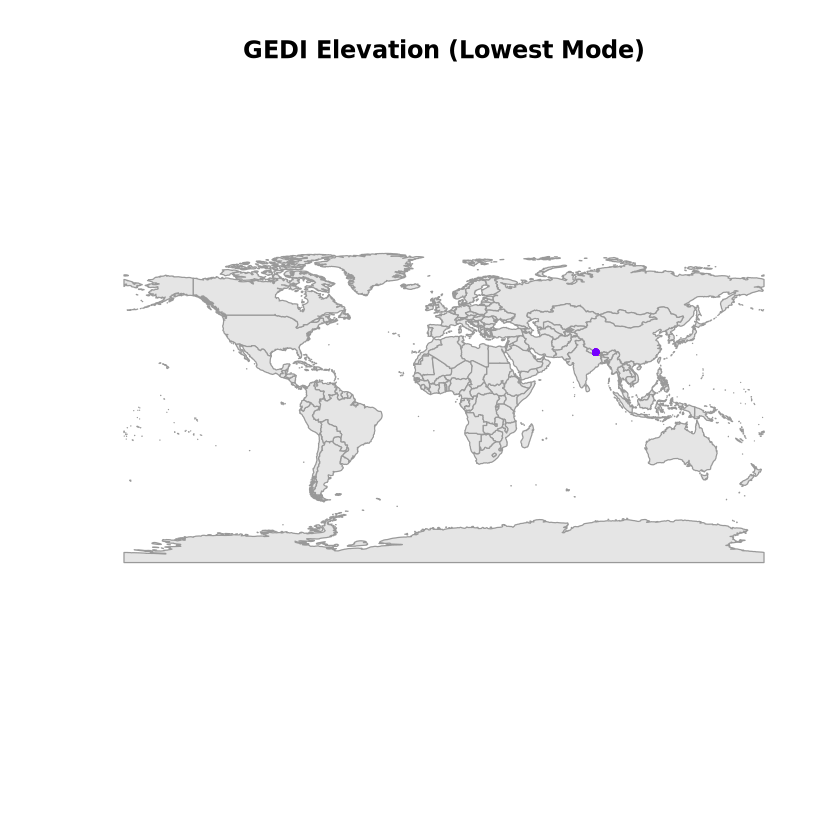

In [71]:
plot(st_geometry(world), col = "grey90", border = "grey60", main = "GEDI Elevation (Lowest Mode)")
plot(df_sf["elev_lowestmode"], add = TRUE, pch = 20)


## Static GEDI Map using Tmap()

This map visualizes GEDI footprint locations on a basemap using `tmap` in static plotting mode. It is a versatile R package that allows users to create both static and interactive maps with minimal effort. It integrates smoothly with `sf` objects and provides intuitive, layered syntax for visualizing spatial dat

tmap mode set to plotting

Warning message:
“Currect projection of shape df_sf unknown. Long-lat (WGS84) is assumed.”


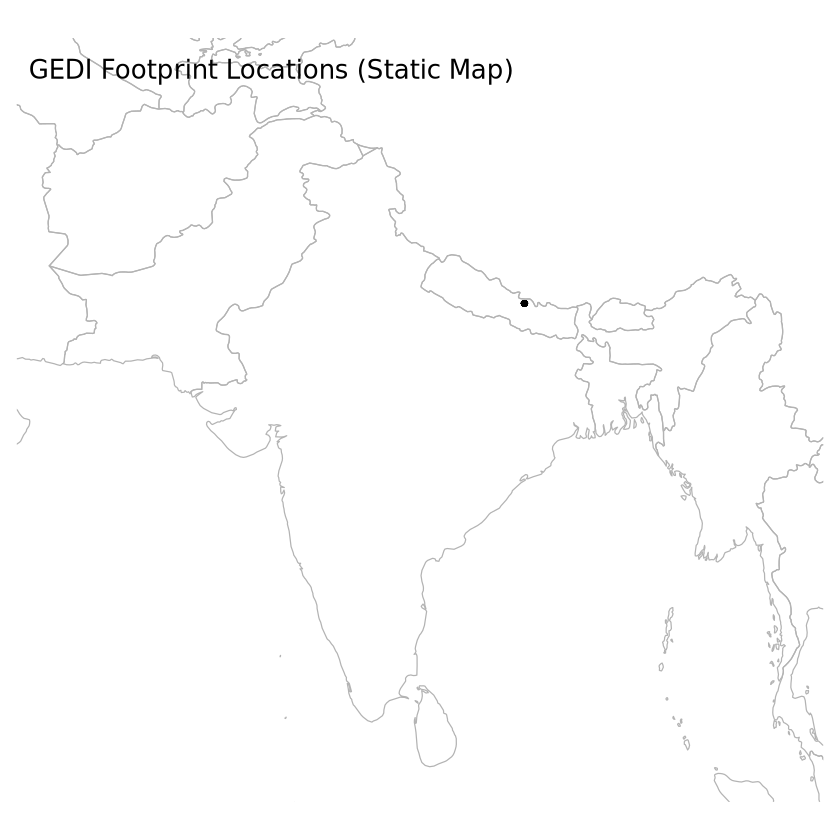

In [70]:
tmap_mode("plot")  

tm_shape(world, bbox = sf::st_bbox(c(xmin = 60, xmax = 100, ymin = 5, ymax = 40), crs = st_crs(world))) +
  tm_borders(col = "gray70") +
  tm_shape(df_sf) +
  tm_dots(
    size = 0.05, 
  ) +
  tm_layout(
    title = "GEDI Footprint Locations (Static Map)",
    frame = FALSE,
    legend.show = FALSE
  )
